# Testing gym4ReaL within Dam environment

This notebook provides examples of usage and comparison of rule-based policies with a PPO agent

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/giovannidispoto/Desktop/PhD/gym4ReaL_github/gym4ReaL


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import tqdm

import gymnasium as gym
from gymnasium.wrappers import RescaleAction

from gym4real.envs.dam.utils import parameter_generator

In [3]:
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context("paper")
plot_colors = sns.color_palette('colorblind')
sns.set(font_scale=1.2)

alg_color = {
    'random': plot_colors[1],
    'mean_action': plot_colors[2],
    'max_action': plot_colors[3],
    'exp_avg_demand_action': plot_colors[4],
    'ppo': plot_colors[6]
}

alg_markers = {
    'random': '.',
    'mean_action': 'o',
    'max_action': 'v',
    'exp_avg_demand_action': 'P',
    'ppo': '*',
}

alg_labels = {
    'random': 'Random',
    'mean_action': 'Mean',
    'max_action': 'Max',
    'exp_avg_demand_action': 'EAD',
    'ppo': 'PPO',
}

In [4]:
n_episodes = 13
rewards = {}

## Initialization of the environment

In [8]:
eval_params = parameter_generator(
    world_options='./gym4real/envs/dam/world_test.yaml',
    lake_params='./gym4real/envs/dam/lake.yaml'
)

eval_env = gym.make('gym4real/dam-v0', settings=eval_params)

print(type(eval_env))

<class 'gymnasium.wrappers.common.OrderEnforcing'>


/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


### Deterministic policies

Here we will show three rule-based policies:
1. random action policy
2. fixed action policy
3. exponential average demand policy

### Random policy
The action is chosen randomly at each decision step.

In [9]:
alg = 'random'
rewards[alg] = []

for episode in tqdm(range(n_episodes)):
    obs, info = eval_env.reset(options={'rewind_profiles': episode == 0})
    done = False
    rewards_episode = []

    while not done:
        action = eval_env.action_space.sample()  # Randomly select an action
        obs, reward, terminated, truncated, info = eval_env.step(action)  # Return observation and reward
        done = terminated or truncated
        rewards_episode.append(info['weighted_reward'])

    rewards[alg].append(rewards_episode)

100%|██████████| 13/13 [00:00<00:00, 38.10it/s]


### Mean action policy
The action is fixed to the center of the action space for each decision step.

In [10]:
alg = 'mean_action'
rewards[alg] = []

mean_action = (eval_env.action_space.high + eval_env.action_space.low) / 2

for episode in tqdm(range(n_episodes)):
    obs, info = eval_env.reset(options={'rewind_profiles': episode == 0})
    done = False
    rewards_episode = []

    while not done:
        action = mean_action
        obs, reward, terminated, truncated, info = eval_env.step(action)  # Return observation and reward
        done = terminated or truncated
        rewards_episode.append(info['weighted_reward'])

    rewards[alg].append(rewards_episode)

100%|██████████| 13/13 [00:00<00:00, 96.63it/s]


### Max action policy
The action is fixed to the maximum for each decision step.

In [11]:
alg = 'max_action'
rewards[alg] = []

max_action = eval_env.action_space.high

for episode in tqdm(range(n_episodes)):
    obs, info = eval_env.reset(options={'rewind_profiles': episode == 0})
    done = False
    rewards_episode = []

    while not done:
        action = max_action
        obs, reward, terminated, truncated, info = eval_env.step(action)  # Return observation and reward
        done = terminated or truncated
        rewards_episode.append(info['weighted_reward'])

    rewards[alg].append(rewards_episode)

100%|██████████| 13/13 [00:00<00:00, 102.01it/s]


### Exponential average demand policy
The action is the exponential average of the past demand in the observation vector

In [12]:
alg = 'exp_avg_demand_action'
rewards[alg] = []

for episode in tqdm(range(n_episodes)):
    obs, info = eval_env.reset(options={'rewind_profiles': episode == 0})
    done = False
    rewards_episode = []

    while not done:
        action = info['exponential_average_demand']
        obs, reward, terminated, truncated, info = eval_env.step(action)  # Return observation and reward
        done = terminated or truncated
        rewards_episode.append(info['weighted_reward'])

    rewards[alg].append(rewards_episode)

100%|██████████| 13/13 [00:00<00:00, 75.70it/s]


### PPO agent

#### Training

In [14]:
import torch

# import the skrl components to build the RL system
from skrl.agents.torch.ppo import PPO, PPO_DEFAULT_CONFIG
from skrl.envs.wrappers.torch import wrap_env
from skrl.memories.torch import RandomMemory
from skrl.resources.preprocessors.torch import RunningStandardScaler
from skrl.resources.schedulers.torch import KLAdaptiveRL
from skrl.trainers.torch import SequentialTrainer
from skrl.utils import set_seed

from gym4real.algorithms.dam.ppo_skrl import Policy, Value

In [18]:
params = parameter_generator(
    world_options='./gym4real/envs/dam/world_train.yaml',
    lake_params='./gym4ReaL/envs/dam/lake.yaml'
)

env = gym.make('gym4real/dam-v0', settings=params)
env = RescaleAction(env, min_action=-1., max_action=1.)
env = wrap_env(env)

/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
[skrl:INFO] Environment wrapper: 'auto' (class: gymnasium.core.Env, gymnasium.utils.record_constructor.RecordConstructorArgs, gymnasium.wrappers.transform_action.TransformAction)
[skrl:INFO] Environment wrapper: gymnasium
[skrl:WARNING] Failed to check for a vectorized environment: module 'gymnasium.experimental' has no attribute 'vector'


In [19]:
set_seed(123)
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_arch = (16, 16)

memory = RandomMemory(memory_size=2048, num_envs=env.num_envs, device=device)

models = {}
models["policy"] = Policy(env.observation_space, env.action_space, device=device, net_arch=net_arch, initial_log_std=-0.5)#, clip_actions=True)
models["value"] = Value(env.observation_space, env.action_space, device=device, net_arch=net_arch)

cfg = PPO_DEFAULT_CONFIG.copy()
cfg["rollouts"] = 2048
cfg["learning_epochs"] = 10
cfg["mini_batches"] = 32
cfg["discount_factor"] = 0.995
cfg["lambda"] = 0.95
cfg["learning_rate"] = 8e-6
cfg["learning_rate_scheduler"] = KLAdaptiveRL
cfg["learning_rate_scheduler_kwargs"] = {"kl_threshold": 0.008}
cfg["grad_norm_clip"] = 0.5
cfg["ratio_clip"] = 0.2
cfg["value_clip"] = 0.2
cfg["clip_predicted_values"] = False
cfg["entropy_loss_scale"] = 0.
cfg["value_loss_scale"] = 0.5
cfg["kl_threshold"] = 0
cfg["mixed_precision"] = True
cfg["state_preprocessor"] = RunningStandardScaler
cfg["state_preprocessor_kwargs"] = {"size": env.observation_space, "device": device}
cfg["value_preprocessor"] = RunningStandardScaler
cfg["value_preprocessor_kwargs"] = {"size": 1, "device": device}
# logging to TensorBoard and write checkpoints (in timesteps)
cfg["experiment"]["write_interval"] = 500
# cfg["experiment"]['experiment_name'] = args['exp_name']
cfg["experiment"]["checkpoint_interval"] = 500
cfg["experiment"]["directory"] = "runs/lake"

agent = PPO(models=models,
            memory=memory,
            cfg=cfg,
            observation_space=env.observation_space,
            action_space=env.action_space,
            device=device
            )

cfg_trainer = {"timesteps": 200000, "headless": True}
trainer = SequentialTrainer(cfg=cfg_trainer, env=env, agents=[agent])
agent.set_mode("eval")

[skrl:INFO] Seed: 123


In [20]:
trainer.train()

100%|██████████| 200000/200000 [02:18<00:00, 1443.69it/s]


#### Training data plots

In [21]:
import os
import glob

log_dirs = sorted(glob.glob(cfg["experiment"]["directory"] + "/*"), key=os.path.getmtime)
latest_log_dir = log_dirs[-1] if log_dirs else None
print(f"Latest log directory: {latest_log_dir}")

Latest log directory: runs/lake/25-05-15_10-17-22-705726_PPO


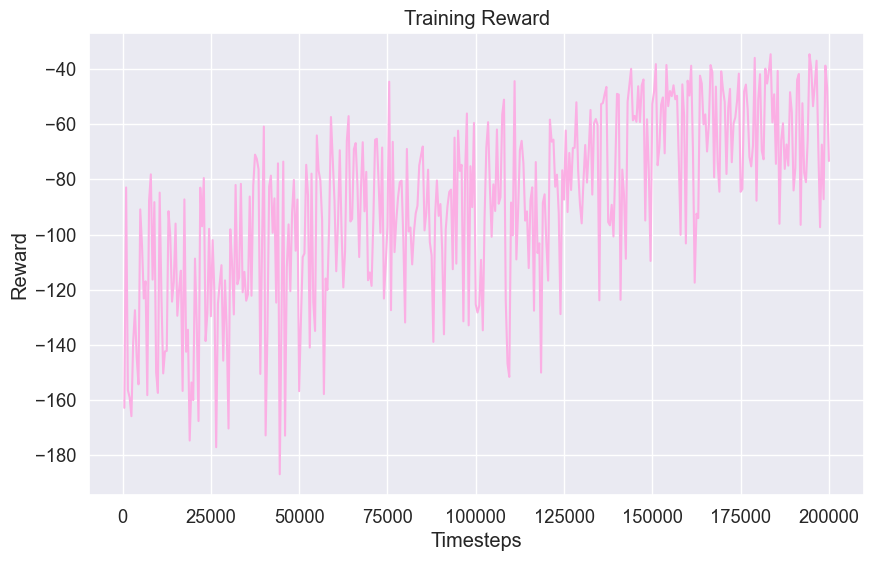

In [22]:
from tensorboard.backend.event_processing import event_accumulator

ea = event_accumulator.EventAccumulator(latest_log_dir)
ea.Reload()

tag = "Reward / Instantaneous reward (mean)"
events = ea.Scalars(tag)

steps = [e.step for e in events]
values = [e.value for e in events]

plt.figure(figsize=(10, 6))
plt.plot(steps, values, color=alg_color['ppo'])
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("Training Reward")
plt.grid(True)

In [23]:
alg = 'ppo'
rewards[alg] = []

scaled_eval_env = RescaleAction(eval_env, min_action=-1., max_action=1.)
scaled_eval_env = wrap_env(scaled_eval_env)
scaled_eval_env.curr_year_data = None

with torch.no_grad():

    for episode in tqdm(range(n_episodes)):
        obs, info = scaled_eval_env.reset()
        done = False
        rewards_episode = []
        timesteps = 0
        while not done:
            output = agent.act(obs, timesteps, 365)
            action = output[-1]['mean_actions']
            obs, reward, terminated, truncated, info = scaled_eval_env.step(action)  # Return observation and reward
            done = terminated or truncated
            rewards_episode.append(info['weighted_reward'])
            timesteps += 1

        rewards[alg].append(rewards_episode)


/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
[skrl:INFO] Environment wrapper: 'auto' (class: gymnasium.core.Env, gymnasium.utils.record_constructor.RecordConstructorArgs, gymnasium.wrappers.transform_action.TransformAction)
[skrl:INFO] Environment wrapper: gymnasium
[skrl:WARNING] Failed to check for a vectorized environment: module 'gymnasium.experimental' has no attribute 'vector'
100%|██████████| 13/13 [00:01<00:00, 11.55it/s]


In [24]:
algs_to_compare = ['random', 'mean_action', 'max_action', 'exp_avg_demand_action', 'ppo']

In [25]:
# convert, for all policies, from list of dicts to dict of arrays
rewards = {key: [{
        r_type: np.array([prof[i][r_type] for i in range(len(prof))]) for r_type in prof[0].keys()
    } for prof in rewards[key]] for key in rewards.keys()
}

In [26]:
rewards_types_to_plot = ['overflow_reward', 'starving_reward', 'daily_deficit_reward']#, 'wasted_water_reward']#, 'clipping_reward']
# rewards_types_to_plot = ['starving_reward']

rewards_to_plot = {key: [sum([prof[r_type] for r_type in rewards_types_to_plot]) for prof in rewards[key]] for key in rewards.keys()}
cum_rewards = {key: [np.cumsum(prof) for prof in val] for key, val in rewards_to_plot.items()}

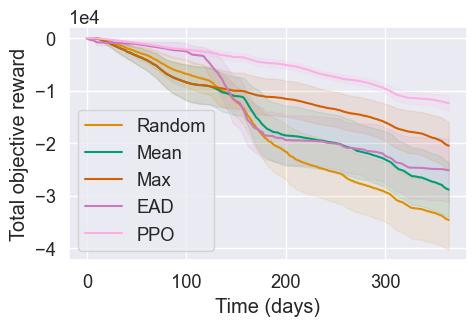

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), tight_layout=True)

for alg in cum_rewards.keys():
    means = np.mean(cum_rewards[alg], axis=0)
    stds = np.std(cum_rewards[alg], axis=0)
    ci = 1.96 * stds/np.sqrt(len(cum_rewards[alg]))

    ax.plot(means, label=alg_labels[alg], color=alg_color[alg])
    ax.fill_between(range(len(means)), means + ci, means - ci, color=alg_color[alg], alpha=0.1)
    ax.legend()

ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.set_xlabel('Time (days)')
ax.set_ylabel('Total objective reward')

fig.savefig('examples/dam/dam_avg_reward.pdf')

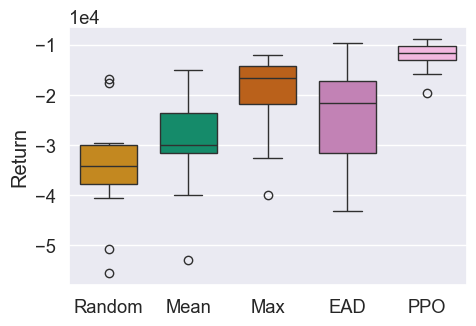

In [28]:
from matplotlib.ticker import ScalarFormatter


box_data = {}
colors = []

for alg in rewards_to_plot.keys():
    box_data[alg_labels[alg]] = [np.sum(prof) for prof in rewards_to_plot[alg]]
    colors.append(alg_color[alg])

fig, ax = plt.subplots(figsize=(5, 3.5), tight_layout=True)
box_plot = sns.boxplot(box_data, gap=.1, palette=colors, width=.8)

medians = [np.mean(values) for key, values in box_data.items()]
vertical_offset = -130 # offset from median for display

# for xtick, alg in zip(box_plot.get_xticks(), rewards.keys()):
#     box_plot.text(xtick,
#                   vertical_offset,
#                   round(medians[xtick]),
#                   horizontalalignment='center',
#                   size='x-small',
#                   color=alg_color[alg],
#                   weight='semibold')

ax.set_ylabel('Return')


formatter = ScalarFormatter()
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 3))  # Show scientific notation when appropriate
ax.yaxis.set_major_formatter(formatter)

fig.savefig('examples/dam/dam_boxplot.pdf')